In [280]:
import json
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [374]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error

In [324]:
seed = 12132707
np.random.seed(seed)

In [244]:
df = pd.concat([pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/ProcessedSurveyDataWithID_%d.csv" % i) 
                       for i in range(2020,2023)])
df = df[df['Country']=='United States of America']
df = df.dropna(subset=['AnnualComp(USD)'])
df.head(3)

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,PID
1,49971,289287,30-34,Man,United States of America,No,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_2020
3,49973,507,30-34,Man,United States of America,No,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_2020
11,49981,742,35-39,Man,United States of America,No,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12_2020


In [317]:
df.shape

(4763, 567)

In [321]:
df.columns.tolist()

['Unnamed: 0',
 'Duration (in seconds)',
 'Age',
 'Gender',
 'Country',
 'IsStudent',
 'MOOCPlatforms_Coursera',
 'MOOCPlatforms_edX',
 'MOOCPlatforms_Kaggle Learn Courses',
 'MOOCPlatforms_DataCamp',
 'MOOCPlatforms_Fast.ai',
 'MOOCPlatforms_Udacity',
 'MOOCPlatforms_Udemy',
 'MOOCPlatforms_LinkedIn Learning',
 'MOOCPlatforms_Cloud-certification programs (direct from AWS, Azure, GCP, or similar)',
 'MOOCPlatforms_University Courses (resulting in a university degree)',
 'MOOCPlatforms_None',
 'MOOCPlatforms_Other',
 'IntroToDSPlatform_University courses',
 'IntroToDSPlatform_Online courses (Coursera, EdX, etc)',
 'IntroToDSPlatform_Social media platforms (Reddit, Twitter, etc)',
 'IntroToDSPlatform_Video platforms (YouTube, Twitch, etc)',
 'IntroToDSPlatform_Kaggle (notebooks, competitions, etc)',
 'IntroToDSPlatform_None / I do not study data science',
 'IntroToDSPlatform_Other',
 'HighestEducation',
 'HasPublishedResearch',
 'TheoreticalResearch',
 'AppliedResearch',
 'NonMLResearch'

## High Level Plan
1. Preprocessing for Regression, EDA
2. Feature selection
3. Models: Linear Regression, Lasso, Ridge, RF regression, XGBoost
4. Investigation: Plot of preds vs actual; GLMs: NB regression.
5. Modeling results: Table of diff regression models with metrics, SD on k-fold CV
6. Interpretability: Feature importance scores; Explain Preds using Shap

In [318]:
order = ["1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999", "5,000-7,499", "7,500-9,999", 
         "10,000-14,999", "15,000-19,999", "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999", 
         "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999", "90,000-99,999", "100,000-124,999", 
         "125,000-149,999", "150,000-199,999", "200,000-249,999", "250,000-299,999", "300,000-499,999", 
         "$500,000-999,999", ">$1,000,000"]

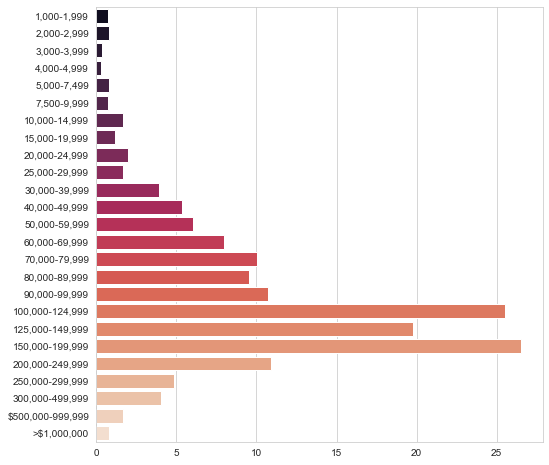

In [538]:
s = df['AnnualComp(USD)'].value_counts()
s = s/len(s)

plt.figure(figsize=(8,8))
sns.barplot(s.values, s.index, palette='rocket', order=order)
plt.show()

# 1. Preprocessing

## 1.1 Salary: Categorical -> Numeric 

### Problem:
The salaries are reported on a categorical scale, and have unequal bin widths. Exp: 1-2k, 2.5-5k, 125k-150k. These need to be converted to a numerical scale.

### Possible solutions
1. Assume a **uniform distribution** over the lower and upper salary limit. For exp, for salary range 1-2k, sample a salary uniformly between 1-2k.
2. Sample a no. s between 0 and 1 from a **Beta distribution** centered at 0.5. Sampled salary = LL + s (UL - LL).
3. Get the distribution of salaries from a tech salaries dataset. Normalize the densities in a constrained range and sample from the constrained distribution using **Inverse Transform sampling** (for exp, normalize densities bw 125k-150k to integrate to 1, and sample from this distribution).

In [246]:
sal = pd.read_csv("./salaries.csv")
sal[sal['company_location'] == 'US']
sal.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Analyst,177000,USD,177000,US,0,US,M
1,2022,SE,FT,Data Analyst,131000,USD,131000,US,0,US,M
2,2022,SE,FT,Applied Scientist,205000,USD,205000,US,100,US,M


In [247]:
sal['work_year'].value_counts()

2022    1163
2021     224
2020      75
Name: work_year, dtype: int64

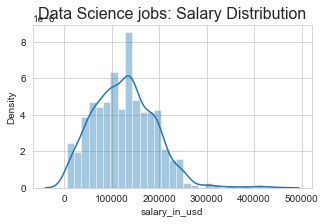

In [248]:
plt.figure(figsize=(5,3))
sns.distplot(sal['salary_in_usd'])
plt.title("Data Science jobs: Salary Distribution", size=16)
plt.show()

In [249]:
def compute_cdf(salaries): # Empirical CDF
    cdf = np.cumsum(salaries)
    cdf = (cdf - cdf.min())/(cdf.max() - cdf.min()) # Normalize from 0 to 1
    return cdf

In [250]:
# Inverse Transform Sampling
salaries = np.sort(sal['salary_in_usd'])
cdf = compute_cdf(salaries) # Empirical CDF
inverse_cdf = scipy.interpolate.interp1d(cdf, salaries) # Interpolate values of salary for all vals bw 0 & 1
inverse_cdf(0.1) # Inverse transform sampling to sample from the required distribution

array(80000.)

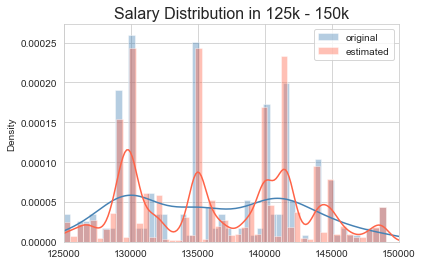

In [251]:
# Suppose we want samples for salary category 125k-150k
sal_1 = salaries[(salaries >= 125000) & (salaries < 150000)]
sal_1 = np.sort(sal_1)
cdf = compute_cdf(sal_1)
inverse_cdf = scipy.interpolate.interp1d(cdf, sal_1)

# Inverse Transform Sampling
u = np.random.random(size=10**5) # Uniform samples

plt.figure(figsize=(6,4))
sns.distplot(sal_1, color='steelblue', label='original', bins=50)
sns.distplot(inverse_cdf(u), color='tomato', label='estimated')
plt.xlim(125000, 150000)
plt.title("Salary Distribution in 125k - 150k", size=16)
plt.legend()
plt.show()

In [252]:
salary_grps = [(1000,1999), (2000,2999), (3000,3999), (4000,4999), (5000,7499), (7500,9999), (10000,14999),
        (15000,19999), (20000,24999), (25000,29999), (30000,39999), (40000,49999), (50000,59999), (60000,69999),
        (70000,79999), (80000,89999), (90000,99999), (100000,124999), (125000,149999), (150000,199999),
        (200000,249999), (250000,299999), (300000,499999), (500000,999999), (1000000,1000000)]

In [253]:
inverse_cdfs = {}
salaries = np.sort(sal['salary_in_usd'])

for ll, ul in salary_grps:
    sals = salaries[(salaries >= ll) & (salaries < ul)]
    if len(sals) < 20:
        #print(ll, len(sals))
        continue
    sals = np.insert(sals, 0, ll)
    sals = np.insert(sals, len(sals), ul)
    sals = np.sort(sals)
    cdf = compute_cdf(sals)
    inverse_cdf = scipy.interpolate.interp1d(cdf, sals)
    inverse_cdfs[ll] = inverse_cdf

In [254]:
def sample_salary(sal_categ, salary_grps, inverse_cdfs):
    if sal_categ == "> $500,000":
        return np.random.uniform(500000, 1000000)
    
    elif sal_categ == ">$1,000,000":
        return np.random.uniform(1000000, 1500000)
    
    else:
        sal_categ = sal_categ.replace(',', '').replace('$', '')
        sal_categ = sal_categ.strip()

        lims = sal_categ.split('-')
        ll = int(lims[0])
        ul = int(lims[1])

        if(ll in inverse_cdfs):
            u = np.random.uniform(0,1) # Uniform sample bw 0, 1
            return inverse_cdfs[ll](u)

            return np.random.uniform(ll, ul) # If insufficient no. of samples, assume uniform distribution

In [255]:
df['salary'] = df['AnnualComp(USD)'].apply(lambda sal: sample_salary(sal, salary_grps, inverse_cdfs))

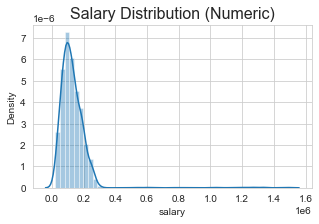

In [256]:
plt.figure(figsize=(5,3))
sns.distplot(df['salary'])
plt.title("Salary Distribution (Numeric)", size=16)
plt.show()

## Feature Engineering

In [259]:
feature_df = pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/DS-MLE-DA-DE-RS-FeatureEngineered.csv")
feature_df.head(3)

,PID,CurrentTitle,Age,NumCoursePlatforms,EduOrdinal,ProgExpOrdinal,NumProgLanguages,MLExpOrdinal,NumMLFrameworks,NumTransferLearning,...,UsedGraphModels,UsedGCP,UsedAWS,UsedAzure,UsedRelationalDBs,UsedNonRelationalDBs,UsedPowerBI,UsedTableau,UsedGPU,UsedE2EPipelineAutomation
0,2_2020,Data Engineer,30-34,3,3.0,5.0,3.0,2.0,4.0,0.0,...,0.0,1,1,1,1,0,1,1,1,0
1,4_2020,Data Scientist,30-34,4,3.0,5.0,3.0,4.0,4.0,0.0,...,0.0,0,1,0,1,0,0,1,0,0
2,6_2020,Data Analyst,30-34,0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [263]:
feature_df.columns

Index(['PID', 'CurrentTitle', 'Age', 'NumCoursePlatforms', 'EduOrdinal',
       'ProgExpOrdinal', 'NumProgLanguages', 'MLExpOrdinal', 'NumMLFrameworks',
       'NumTransferLearning', 'NumCloudProvidersUsed', 'NumCloudComputeUsed',
       'NumCloudStorageUsed', 'NumBIToolsUsed', 'NumMLaaSToolsUsed',
       'NumAutoMLUsed', 'NumMLDeploymentToolsUsed', 'NumMLMonitoringToolUsed',
       'NumHardwareUsed', 'TPUUsageOrdinal', 'NumDSContentMediaConsumed',
       'NumStepsOfPipelineAutomated', 'CompletedUniDegree', 'UsedPython',
       'UsedR', 'UsedSQL', 'UsedJupyter', 'UsedPyViz', 'UsedRViz', 'UsedJSViz',
       'UsedSKlearn', 'UsedTFKeras', 'UsedPyTorch', 'UsedHF', 'UsedFastAI',
       'UsedLinearModels', 'UsedTreeModels', 'UsedGBModels',
       'UsedBayesianModels', 'UsedEvolutionaryModels', 'UsedNNModels',
       'UsedCNNModels', 'UsedGANModels', 'UsedTransformerModels',
       'UsedAEModels', 'UsedRNNModels', 'UsedGraphModels', 'UsedGCP',
       'UsedAWS', 'UsedAzure', 'UsedRelationalDBs

In [261]:
len(df)

4763

In [294]:
df_merged = df[["PID", "salary"]].merge(feature_df, on="PID")
df_merged = df_merged.dropna(subset=["salary"])
df_merged.head(3)

,PID,salary,CurrentTitle,Age,NumCoursePlatforms,EduOrdinal,ProgExpOrdinal,NumProgLanguages,MLExpOrdinal,NumMLFrameworks,...,UsedGraphModels,UsedGCP,UsedAWS,UsedAzure,UsedRelationalDBs,UsedNonRelationalDBs,UsedPowerBI,UsedTableau,UsedGPU,UsedE2EPipelineAutomation
0,2_2020,101228.534003,Data Engineer,30-34,3,3.0,5.0,3.0,2.0,4.0,...,0.0,1,1,1,1,0,1,1,1,0
1,4_2020,144000.000000,Data Scientist,30-34,4,3.0,5.0,3.0,4.0,4.0,...,0.0,0,1,0,1,0,0,1,0,0
2,12_2020,34750.771364,Research Scientist,35-39,0,4.0,2.0,1.0,1.0,1.0,...,0.0,0,0,0,0,0,0,0,0,0


In [397]:
df_merged.shape

(2363, 57)

In [378]:
enc_age = OrdinalEncoder(categories=[np.sort(df_merged["Age"].unique())])
df_merged["Age_categ"] = enc_age.fit_transform(df_merged["Age"].to_numpy().reshape(-1,1))
df_merged = df_merged.drop("Age", axis=1)

In [394]:
ohe_job = OneHotEncoder(drop='first')
title_ohe_df = ohe_job.fit_transform(np.array(df_merged["CurrentTitle"]).reshape(-1,1)).toarray()
job_titles = ohe_job.categories_[0][1:]
title_ohe_df = pd.DataFrame(title_ohe_df, columns = job_titles)
title_ohe_df.head(3) # OHE For linear models

,Data Engineer,Data Scientist,Machine Learning Engineer,Research Scientist
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0


In [402]:
CATEGORICAL_FEATURES = ["Age", "CurrentTitle"]

BINARY_FEATURES = ["CompletedUniDegree", "UsedPython", "UsedR", "UsedSQL", "UsedJupyter", "UsedPyViz", "UsedRViz",
                   "UsedJSViz", "UsedSKlearn", "UsedTFKeras", "UsedPyTorch", "UsedHF", "UsedFastAI", 
                   "UsedLinearModels","UsedTreeModels","UsedGBModels","UsedBayesianModels",
                   "UsedEvolutionaryModels","UsedNNModels","UsedCNNModels","UsedGANModels",
                   "UsedTransformerModels","UsedAEModels","UsedRNNModels","UsedGraphModels", "UsedGCP", 
                   "UsedAWS", "UsedAzure", "UsedRelationalDBs","UsedNonRelationalDBs", "UsedPowerBI",
                   "UsedTableau", "UsedGPU", "UsedE2EPipelineAutomation", 
#                    "Data Engineer", "Data Scientist", "Machine Learning Engineer", "Research Scientist"
                  ]

NUMERICAL_FEATURES = ["NumCoursePlatforms", "EduOrdinal", "ProgExpOrdinal", "NumProgLanguages", "MLExpOrdinal", 
                      "NumMLFrameworks", "NumTransferLearning", "NumCloudProvidersUsed", "NumCloudComputeUsed", 
                      "NumCloudStorageUsed", "NumBIToolsUsed", "NumMLaaSToolsUsed", "NumAutoMLUsed", 
                      "NumMLDeploymentToolsUsed", "NumMLMonitoringToolUsed", "NumHardwareUsed", 
                      "TPUUsageOrdinal", "NumDSContentMediaConsumed", "NumStepsOfPipelineAutomated"]

### Numeric features most correlated to Salary

In [403]:
df_merged[NUMERICAL_FEATURES + ["salary"]].corr()['salary'].sort_values(ascending=False)[1:16]

MLExpOrdinal                   0.308219
ProgExpOrdinal                 0.268608
NumHardwareUsed                0.189866
NumMLFrameworks                0.167314
NumCloudStorageUsed            0.162663
NumCloudProvidersUsed          0.157257
NumStepsOfPipelineAutomated    0.147373
NumMLMonitoringToolUsed        0.146176
TPUUsageOrdinal                0.141245
NumCloudComputeUsed            0.138601
NumMLaaSToolsUsed              0.131786
NumAutoMLUsed                  0.103165
NumBIToolsUsed                 0.094550
NumProgLanguages               0.088345
NumTransferLearning            0.080183
Name: salary, dtype: float64

### Binary features most related to Salary (Mutual Information)

In [404]:
mi_scores = mutual_info_regression(df_merged[BINARY_FEATURES], df_merged["salary"])
mi_df = []

for i in np.argsort(mi_scores)[::-1][:15]:
    mi_df.append([BINARY_FEATURES[i], np.round(mi_scores[i],3)])
    
mi_df = pd.DataFrame(mi_df, columns=['Feature', 'Mutual Information'])
mi_df

,Feature,Mutual Information
0,UsedGBModels,0.052
1,UsedAWS,0.032
2,UsedSKlearn,0.031
3,UsedPyViz,0.021
4,UsedNNModels,0.021
5,UsedLinearModels,0.019
6,UsedTransformerModels,0.018
7,UsedPowerBI,0.016
8,UsedE2EPipelineAutomation,0.016
9,UsedAzure,0.014


## To Do
1. Check multicollinearity
2. Outliers

# Modeling

In [408]:
X_train, X_test, y_train, y_test = train_test_split(
                                df_merged.drop(['PID', 'CurrentTitle', 'salary'], axis=1), df_merged['salary'], 
                                test_size=0.20, random_state=seed)

In [409]:
X_train.shape

(1890, 54)

In [579]:
def get_regression_metrics(model, X, y_true, label):
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    maxerror = max_error(y_true, y_pred)
    
    metrics = pd.DataFrame({"R2":round(r2,3), "RMSE":round(rmse,3), "MAE":round(mae,3),
                            "MAPE":round(mape,3), "Max Error":round(maxerror,3)},
                           index=[f"{label}"]).T
    return metrics

In [577]:
def get_train_test_metrics(model, X_train, y_train, X_test, y_test):
    train_metrics = get_regression_metrics(model, X_train, y_train, "Train")
    test_metrics = get_regression_metrics(model, X_test, y_test, "Test")
    return train_metrics.join(test_metrics)

In [572]:
def plot_true_pred(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = lr_model.predict(X_test)

    fig, axs = plt.subplots(1,2, figsize=(11,3), gridspec_kw={"wspace":0.3}, sharey=True)
    axs[0].scatter(y_train, y_pred_train, marker='o', s=2, alpha=0.5, color='lightsalmon')
    axs[1].scatter(y_test, y_pred_test, marker='o', s=2, alpha=0.5, color='lightsalmon')

    x = np.linspace(0, 7e5)
    y = np.linspace(0, 7e5)
    for i in range(2):
        axs[i].plot(x, y, color='darkred', label='Ideal Fit')
        axs[i].set_xlabel("Actual y", fontsize=14, labelpad=8)
        axs[i].set_ylabel("Predicted y", fontsize=14, labelpad=8)
    axs[0].set_title("Train", size=18, pad=8)
    axs[1].set_title("Test", size=18, pad=8)
    plt.legend()
    plt.show()

## Baselines

### Linear Regression

                 Train         Test
R2               0.173        0.200
RMSE        101207.973   100449.407
MAE          46446.563    45656.308
MAPE             0.416        0.389
Max Error  1311319.564  1119737.838


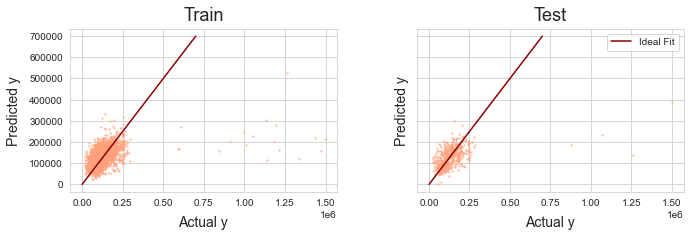

In [580]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print(get_train_test_metrics(lr_model, X_train, y_train, X_test, y_test))
plot_true_pred(lr_model, X_train, y_train, X_test, y_test)

In [583]:
# Test error is actually lower! No need of regularization (Lasso, Ridge, ElasticNet)

### Random Forest Regression

                Train         Test
R2              0.865        0.183
RMSE        40914.130   101524.664
MAE         18561.286    47388.286
MAPE            0.168        0.423
Max Error  489008.366  1105120.810


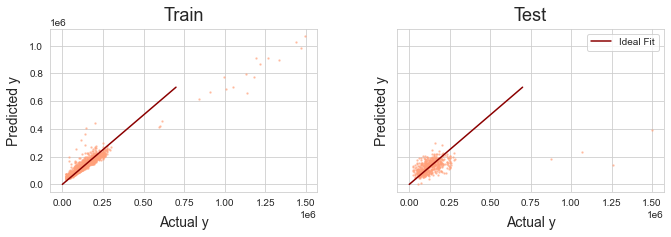

In [584]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
print(get_train_test_metrics(rf_model, X_train, y_train, X_test, y_test))
plot_true_pred(rf_model, X_train, y_train, X_test, y_test)

In [ ]:
# Overfitting!

### XGBoost Regression

                Train         Test
R2              0.987       -0.089
RMSE        12826.620   117175.094
MAE          8247.074    54919.450
MAPE            0.086        0.482
Max Error  171973.161  1162379.152


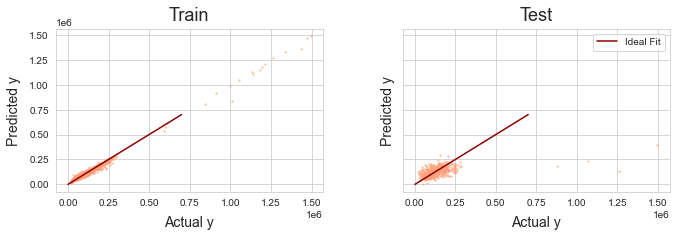

In [585]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
print(get_train_test_metrics(xgb_model, X_train, y_train, X_test, y_test))
plot_true_pred(xgb_model, X_train, y_train, X_test, y_test)

## Hyperparameter Tuning & CV scores

In [560]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_scores = cross_val_score(lr_model, X_train, y_train, scoring="r2", cv=5)

In [459]:
# Ridge Regression
ridge_model = Ridge()
ridge_scores = cross_val_score(ridge_model, X_train, y_train, scoring="r2", cv=5)

In [460]:
# Lasso Regression
lasso_model = Lasso()
lasso_scores = cross_val_score(lasso_model, X_train, y_train, scoring="r2", cv=5)

In [462]:
# Elasticnet Regression
elasticnet_model = ElasticNet()
elasticnet_scores = cross_val_score(elasticnet_model, X_train, y_train, scoring="r2", cv=5)

In [463]:
# Random Forest
rf_model = RandomForestRegressor()
rf_scores = cross_val_score(rf_model, X_train, y_train, scoring="r2", cv=5)

In [464]:
# XGBoost
xgb_model = XGBRegressor()
xgb_scores = cross_val_score(xgb_model, X_train, y_train, scoring="r2", cv=5)

<AxesSubplot:>

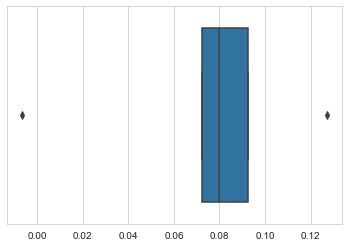

In [465]:
sns.boxplot(lr_scores)

In [432]:
rf_params = {
    "n_estimators": [100, 500]#list(range(100, 1100, 500)),
#     "max_depth": [None, 10, 20, 50],
    
}
# RandomForestRegressor()

In [448]:
# Grid search with 5-fold stratified CV
rf_grid = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring="r2")
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 500]}, scoring='r2')

In [449]:
rf_grid.best_score_

0.008516882328529837

In [454]:
rf_model = RandomForestRegressor(**rf_grid.best_params_)
rf_scores = cross_val_score(rf_model, X_train, y_train, scoring="r2", cv=5)
rf_scores
# Scores: sorted(sklearn.metrics.SCORERS.keys())

array([-0.09793781, -0.02486273,  0.08024714, -0.03433557,  0.01641085])